In [1]:
from IPython.display import Markdown
Markdown(filename="../INDEX.md")

#Table of Contents
<small>Click on the following links to access the revelant content</small>
<br><br>
1. [Data Loading](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/rphoa/python-project-primer/master/notebooks/1.%20Data%20Loading.ipynb)
2. [Data Manipulation](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/rphoa/python-project-primer/master/notebooks/2.%20Data%20Manipulation.ipynb)
3. [Modelling](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/rphoa/python-project-primer/master/notebooks/3.%20Modelling.ipynb)
4. [Saving Output](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/rphoa/python-project-primer/master/notebooks/4.%20Saving%20Output.ipynb)


In [3]:
%matplotlib inline

import math
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict

#optional package
import seaborn as sns
sns.set(style="darkgrid")

###1. Load data from CSV files

In [4]:
df_performance = pd.read_csv("../data/airline_data.csv", header=0)
df_carrier = pd.read_csv("../data/carrier.csv", header=0)

#get the latest carriers
df_carrier = df_carrier[df_carrier["Description"].apply(lambda x: x.find("- )") > 0)]

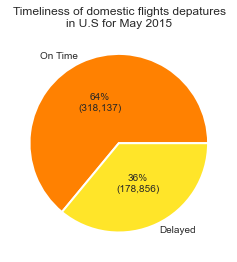

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches([4, 4])

delayed = df_performance["DEP_DELAY_NEW"] > 0
on_time = ~delayed

plt.axis("equal")

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int((pct*total/100.0)+0.5)
        return "{p:.0f}%\n({v:,d})".format(p=pct,v=val)
    return my_autopct

values = [on_time.sum(), delayed.sum()]
plt.pie(
    values, 
    autopct=make_autopct(values), 
    pctdistance=0.5,
    colors=plt.cm.Set1(np.linspace(0.5, 0.6, 2)), 
    labels=["On Time", "Delayed"], 
    labeldistance=1.075,
    wedgeprops = { "linewidth" : 2, "edgecolor": "white" }
)

plt.title("Timeliness of domestic flights depatures \nin U.S for May 2015")
plt.show()

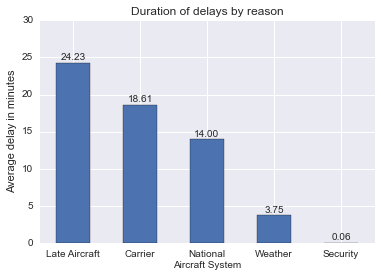

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches([6, 4])
df_delay = df_performance[~pd.isnull(df_performance["CARRIER_DELAY"])]
d = {
    "Carrier": df_delay["CARRIER_DELAY"].mean(),
    "Weather": df_delay["WEATHER_DELAY"].mean(),
    "National\nAircraft System": df_delay["NAS_DELAY"].mean(),
    "Security": df_delay["SECURITY_DELAY"].mean(),
    "Late Aircraft": df_delay["LATE_AIRCRAFT_DELAY"].mean()
}
data = OrderedDict(sorted(d.items(), key=lambda t: -t[1]))
index = np.arange(len(data))
width = 0.5
rects = plt.bar(index + width/2, data.values(), width)
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2., height+0.1, "{:.2f}".format(height), ha="center", va="bottom")

ax.set_ylim([0, 30])
plt.xticks(index + width, list(data.keys()))

plt.ylabel("Average delay in minutes")
plt.title("Duration of delays by reason")

plt.show()

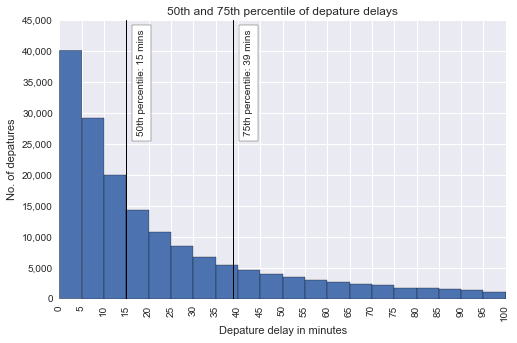

In [133]:
def draw_percentile(p):
    percentile = np.percentile(x, p)
    plt.annotate(
        "{}th percentile: {} mins".format(p, int(percentile)),
        xy=(percentile, plt.ylim()[1]), 
        xytext=(15, -10), 
        size=10, 
        ha="center", 
        va="top", 
        textcoords="offset points", 
        rotation=90,
        bbox=dict(boxstyle="Square,pad=0.5", facecolor="white")
    )
    plt.axvline(x=percentile, ymin=0, ymax=1, linewidth=1, color="k")

field = "DEP_DELAY_NEW"
fig, ax = plt.subplots()
fig.set_size_inches([8, 5])
f = ~pd.isnull(df_performance[field]) & (df_performance[field] > 0) #& (df_performance[field] < 200)
x = df_performance[f][field].values

binwidth = 5
n, bins, patches = plt.hist(x, bins=np.arange(0, int(math.ceil(max(x) / 10.0)) * 10 + binwidth, binwidth))

draw_percentile(50)
draw_percentile(75)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
ax.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(base=5))
ax.set_xlim([0, 100])
plt.setp(ax.xaxis.get_ticklabels(), rotation=90)
plt.title("50th and 75th percentile of depature delays")
plt.xlabel("Depature delay in minutes")
plt.ylabel("No. of depatures")
plt.show()

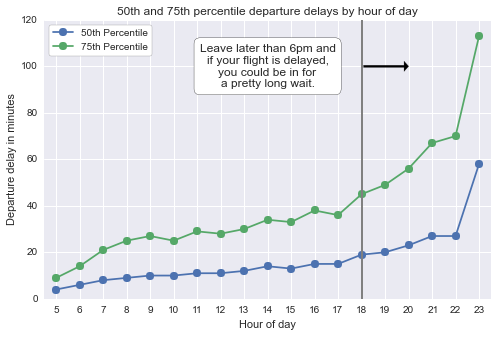

In [155]:
from pandas import concat

fig, ax = plt.subplots()
fig.set_size_inches([8, 5])
field = "DEP_DELAY_NEW"
f = ~pd.isnull(df_performance[field]) & (df_performance[field] > 0) #& (df_performance[field] < 200)
df = df_performance[f].copy()

df["DEP_TIME_HR"] = df["DEP_TIME"].apply(lambda x: "{:04.0f}".format(x)[:2])

g = df.groupby("DEP_TIME_HR")

df_g = g["DEP_DELAY_NEW"].agg({
        "p50" : lambda x: np.percentile(x, 50), 
        "p75" : lambda x: np.percentile(x, 75),
        "n": "count"
    })
df_g = df_g[["n", "p50", "p75"]].reset_index()
df_g = df_g[5:-1]

plt.plot(df_g["DEP_TIME_HR"], df_g["p50"], label="50th Percentile", marker="o", markersize=8)
plt.plot(df_g["DEP_TIME_HR"], df_g["p75"], label="75th Percentile", marker="o", markersize=8)

plt.axvline(x=18, ymin=0, ymax=1, linewidth=2, color="gray")

plt.text(
    14, 100, 
    "Leave later than 6pm and \nif your flight is delayed, \nyou could be in for \na pretty long wait.", 
    size=12,
    horizontalalignment="center", verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white")
)

plt.annotate(
   "", xy=(20, 100), 
    xytext=(-45, 0),
    textcoords="offset points",
    arrowprops=dict(
        headwidth=10,
        facecolor="black",
        width=2)
)

ax.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
ax.set_xlim([4.5, 23.5])

legend = plt.legend(loc="upper left", frameon = True, fancybox = True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("gray")

plt.title("50th and 75th percentile departure delays by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Departure delay in minutes")


plt.show()